# Wines Points prediction 

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('../')

Here we will try to predict the points a wine will get based on known characteristics (i.e. features, in the ML terminology). The mine point in this stage is to establish a simple, ideally super cost effective, basline.
In the real world there is a tradeoff between complexity and perforamnce, and the DS job, among others, is to present a tradeoff tables of what performance is achivalbel at what complexity level. 

to which models with increased complexity and resource demands will be compared. Complexity should then be translated into cost. For example:
 * Compute cost 
 * Maintenance cost
 * Serving costs (i.e. is new platform needed?) 
 

## Loading the data

In [2]:
import pandas as pd
import cufflinks as cf; cf.go_offline()

In [3]:
wine_reviews = pd.read_csv("data/winemag-data-130k-v2.csv")
wine_reviews.shape

(129971, 14)

In [4]:
wine_reviews.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
54999,54999,Spain,Waxy white-fruit aromas are a touch austere an...,Gran Claustro Reserva But Nature,89,27.0,Catalonia,Cava,NaN,Michael Schachner,@wineschach,Perelada 2013 Gran Claustro Reserva But Nature...,Sparkling Blend,Perelada
128095,128095,US,"Bright aromas of raspberries, flowers, potpour...",Foundation,89,38.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Structure 2013 Foundation Syrah (Columbia Vall...,Syrah,Structure
27404,27404,France,"A fruity wine, made to be drunk young, ripe an...",Triguedina Petit Clos,86,20.0,Southwest France,Cahors,NaN,Roger Voss,@vossroger,Jean-Luc Baldès 2011 Triguedina Petit Clos Mal...,Malbec-Merlot,Jean-Luc Baldès
115677,115677,Spain,Initial charred aromas turn to licorice and bl...,Reserva,91,50.0,Northern Spain,Ribera del Duero,NaN,Michael Schachner,@wineschach,Protos 2010 Reserva (Ribera del Duero),Tempranillo,Protos
6468,6468,France,"This is very structured and full, with a power...",NaN,91,56.0,Burgundy,Chassagne-Montrachet,NaN,Roger Voss,@vossroger,Joseph Drouhin 2010 Chassagne-Montrachet,Chardonnay,Joseph Drouhin


In [5]:
wine_reviews = wine_reviews.drop(columns=['Unnamed: 0'])

In [6]:
wine_reviews = wine_reviews.drop_duplicates()
wine_reviews.shape

(119988, 13)

In [7]:
wine_reviews['desc_low'] = wine_reviews['description'].str.lower()
wine_reviews.sample()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,desc_low
73049,US,Cherry cough drops in a pleasant way on the no...,Lauer Vineyard,91,39.0,California,Napa Valley,Napa,NaN,NaN,Jessup Cellars 1997 Lauer Vineyard Cabernet Sa...,Cabernet Sauvignon,Jessup Cellars,cherry cough drops in a pleasant way on the no...


## Points prediction

Points is descrete value target. There for we are talking about a prediction (Regression) problem (in contrary to classification problem). Prediction solutions can be measured in few metrics:

* MSE - [Mean score error](https://en.wikipedia.org/wiki/Mean_squared_error)
* R2 - [R Square](https://en.wikipedia.org/wiki/Coefficient_of_determination)
* MAE - [Mean absolut error](https://en.wikipedia.org/wiki/Mean_absolute_error)

Read more [here](https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b)

### Train and test set split

To properly report results, let's split to train and test datasets:

In [8]:
train_data = wine_reviews.sample(frac = 0.8)
test_data = wine_reviews[~wine_reviews.index.isin(train_data.index)]
assert(len(train_data) + len(test_data) == len(wine_reviews))

In [9]:
len(test_data), len(train_data)

(23998, 95990)

### Baselines

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
def calc_prediction_quality(df, pred_score_col, true_score_col):
    return pd.Series({'MSE': mean_squared_error(df[true_score_col], df[pred_score_col]),
                      'MAE': mean_absolute_error(df[true_score_col], df[pred_score_col]),
                      'R2': r2_score(df[true_score_col], df[pred_score_col])})

#### Baseline 1

The most basic baseline is simply the average points. The implementaion is as simple as:

In [12]:
test_data['basiline_1_predicted_points'] = train_data.points.mean()
b1_stats = calc_prediction_quality(test_data, 'basiline_1_predicted_points', 'points')
b1_stats

MSE    9.458010
MAE    2.520648
R2    -0.000002
dtype: float64

#### Basline 2

We can probably improve by predicting the average score based on the origin country:

In [13]:
avg_points_by_country = train_data.groupby('country').points.mean()
avg_points_by_country.head()

country
Argentina                 86.621424
Armenia                   87.000000
Australia                 88.522235
Austria                   90.102893
Bosnia and Herzegovina    86.500000
Name: points, dtype: float64

In [14]:
test_data['basiline_2_predicted_points'] = test_data.country.map(avg_points_by_country).fillna(train_data.points.mean())
b2_stats = calc_prediction_quality(test_data, 'basiline_2_predicted_points', 'points')
b2_stats

MSE    8.991641
MAE    2.450481
R2     0.049307
dtype: float64

#### Baseline 3

Adding more breakdowns will increase our granularity but can result in overfitting. Yet:

In [15]:
avg_points_by_country_and_region = train_data.groupby(['country','province']).points.mean().rename('basiline_3_predicted_points')
avg_points_by_country_and_region.head()

country    province        
Argentina  Mendoza Province    86.741477
           Other               85.885572
Armenia    Armenia             87.000000
Australia  Australia Other     85.398907
           New South Wales     87.783333
Name: basiline_3_predicted_points, dtype: float64

In [16]:
test_data_with_baseline_3 = test_data.merge(avg_points_by_country_and_region, on = ['country','province'], how='left')
test_data_with_baseline_3.basiline_3_predicted_points = test_data_with_baseline_3.basiline_3_predicted_points.fillna(test_data_with_baseline_3.basiline_2_predicted_points).fillna(test_data.basiline_1_predicted_points)
test_data_with_baseline_3.shape, test_data.shape

((23998, 17), (23998, 16))

In [17]:
b3_stats = calc_prediction_quality(test_data_with_baseline_3, 'basiline_3_predicted_points', 'points')
b3_stats

MSE    8.442267
MAE    2.358453
R2     0.107393
dtype: float64

### Baselines summary

In [18]:
baseline_summary = pd.DataFrame([b1_stats, b2_stats, b3_stats], index=['baseline_1', 'baseline_2','baseline_3'])
baseline_summary

,MSE,MAE,R2
baseline_1,9.458010,2.520648,-0.000002
baseline_2,8.991641,2.450481,0.049307
baseline_3,8.442267,2.358453,0.107393


In [19]:
baseline_summary.to_csv('data/baselines_summary.csv', index=False)

## Training a Boosting trees regressor

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#### Preparing data - Lable encoding categorical features

In [21]:
categorical_features = ['country','province','region_1','region_2','taster_name','variety','winery']
numerical_features = ['price']
features = categorical_features + numerical_features

In [22]:
encoded_features = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features['price'] = wine_reviews.price.fillna(-1)
encoded_features['points'] = wine_reviews.points
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points
0,22,332,424,6,9,691,11608,-1.0,87
1,32,108,738,6,16,451,12956,15.0,87
2,41,269,1218,17,15,437,13018,14.0,87
3,41,218,549,6,0,480,14390,13.0,87
4,41,269,1218,17,15,441,14621,65.0,87


#### Re-splitting to train and test

In [23]:
train_encoded_features = encoded_features[encoded_features.index.isin(train_data.index)]
test_encoded_features = encoded_features[encoded_features.index.isin(test_data.index)]
assert(len(train_encoded_features) + len(test_encoded_features) == len(wine_reviews))

#### Fitting a tree-regressor

In [24]:
from src.models import i_feel_lucky_xgboost_training

In [25]:
train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95990 entries, 0 to 129970
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      95990 non-null  int32  
 1   province     95990 non-null  int32  
 2   region_1     95990 non-null  int32  
 3   region_2     95990 non-null  int32  
 4   taster_name  95990 non-null  int32  
 5   variety      95990 non-null  int32  
 6   winery       95990 non-null  int32  
 7   price        95990 non-null  float64
 8   points       95990 non-null  int64  
dtypes: float64(1), int32(7), int64(1)
memory usage: 4.8 MB


In [ ]:
xgb_clf, clf_name = i_feel_lucky_xgboost_training(train_encoded_features, test_encoded_features, features, 'points', name='xgb_clf_points_prediction')

Let's look at the function output - specifically the **xgb_clf_points_prediction** column:

In [ ]:
test_encoded_features.head()

In [ ]:
xgb_stats = calc_prediction_quality(test_encoded_features, 'xgb_clf_points_prediction','points')
xgb_stats

In [ ]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, xgb_stats], index=['baseline_1', 'baseline_2','baseline_3','regression_by_xgb'])
all_compared

In [ ]:
all_compared.to_csv('data/all_models_compared.csv', index=False)

## Classical NLP approaches

### Using only the text from the "description" column

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

### Data exploration

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
stopwords=nltk.corpus.stopwords.words("english")
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

#### Creating vocabulary from the Train set only:

In [28]:
all_words = [word for desc in train_data.desc_low for word in nltk.word_tokenize(desc) if word.lower() not in stopwords] # Words without stop words
words_df = pd.DataFrame(data = all_words, columns = ['word']).word.value_counts().reset_index()
words_df.columns = ['word','wordCount']
words_df['wordImportance'] = len(words_df) / words_df.wordCount / words_df.wordCount.max()
words_df.head()

,word,wordCount,wordImportance
0,",",326265,3.875758e-07
1,.,261488,4.835879e-07
2,wine,59313,2.131951e-06
3,flavors,46394,2.725620e-06
4,'s,38339,3.298271e-06


In [29]:
words_df.shape

(41257, 3)

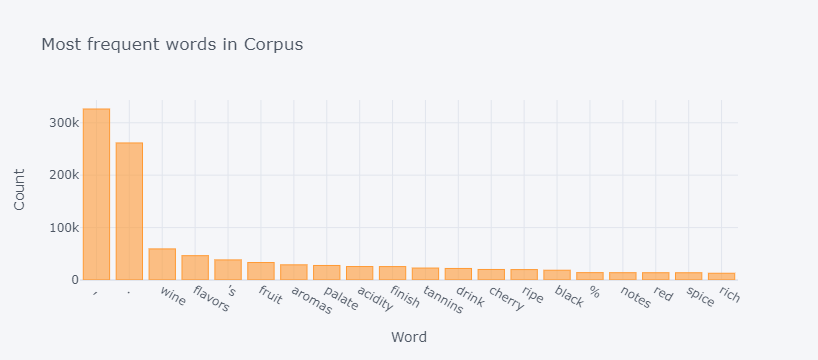

In [30]:
words_df.set_index('word').wordCount.head(20).iplot(kind = 'bar', title = 'Most frequent words in Corpus', yTitle = 'Count', xTitle = 'Word')

In [31]:
print("Total of {} words, {} unique words".format(len(all_words), len(words_df)))

Total of 3047702 words, 41257 unique words


In [32]:
print ("Using words with 4 or more appearances will reduce the corpus size to: {}".format(sum(words_df.wordCount >= 4)))

Using words with 4 or more appearances will reduce the corpus size to: 13985


In [33]:
words_df = words_df[words_df.wordCount >= 4]

#### Bag of words (One-hot-encoding) for Train

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
clean_vocab = set(words_df.word)

In [36]:
count_vect = CountVectorizer(vocabulary = clean_vocab, tokenizer=nltk.word_tokenize)

In [37]:
clean_bow_counts_train = count_vect.fit_transform(train_data.desc_low)
clean_bow_counts_train

<95990x13985 sparse matrix of type '<class 'numpy.int64'>'
	with 2533054 stored elements in Compressed Sparse Row format>

In [38]:
clean_bow_counts_train.shape

(95990, 13985)

#### Bag of words (One-hot-encoding) for Test

In [39]:
clean_bow_counts_test = count_vect.fit_transform(test_data.desc_low)
clean_bow_counts_test

<23998x13985 sparse matrix of type '<class 'numpy.int64'>'
	with 631486 stored elements in Compressed Sparse Row format>

In [40]:
clean_bow_counts_test.shape

(23998, 13985)

### Regression (not Classification)

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, mean_squared_error, r2_score, mean_absolute_error

In [42]:
from sklearn.linear_model import LinearRegression, Ridge

#### Search for the best alpha on the Train set only :

In [43]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, clean_bow_counts_train, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

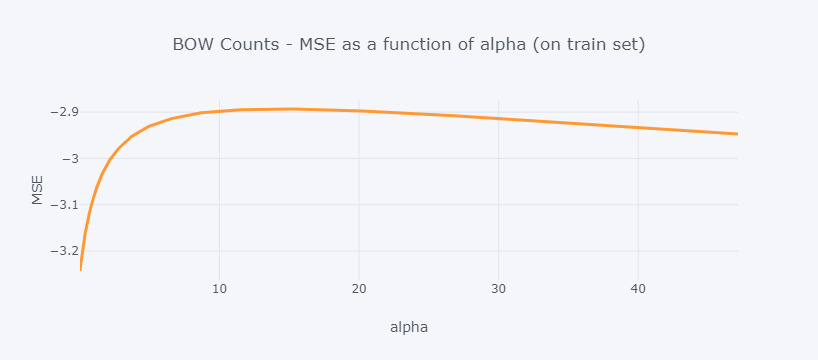

In [44]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [45]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

15.264179671752334 2.8930853733946273


#### Optimal Model : training the model with the best alpha, on the train set:

In [46]:

model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=15.264179671752334)

In [47]:
test_data['ridge_predicted_points'] = model.predict(clean_bow_counts_test)

In [48]:
ridge_stats = calc_prediction_quality(test_data, 'ridge_predicted_points','points')
ridge_stats

MSE    2.890164
MAE    1.344363
R2     0.696301
dtype: float64

In [49]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.516897,2.524463,-0.000038
baseline_2,9.020636,2.449213,0.052110
baseline_3,8.526019,2.367821,0.104084
ridge_stats,2.890164,1.344363,0.696301


### Using both the text and other features

#### Using both the text and other features (encoded in the Boosting trees part)

In [50]:
features

['country',
 'province',
 'region_1',
 'region_2',
 'taster_name',
 'variety',
 'winery',
 'price']

In [51]:
from scipy.sparse import coo_matrix, hstack

In [52]:
train_features_spares_matrix = coo_matrix(train_encoded_features)
train_united_features = hstack((clean_bow_counts_train ,train_features_spares_matrix))

In [53]:
train_features_spares_matrix.shape

(95990, 9)

#### Search for the best alpha on the Train set only :

In [54]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_united_features, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

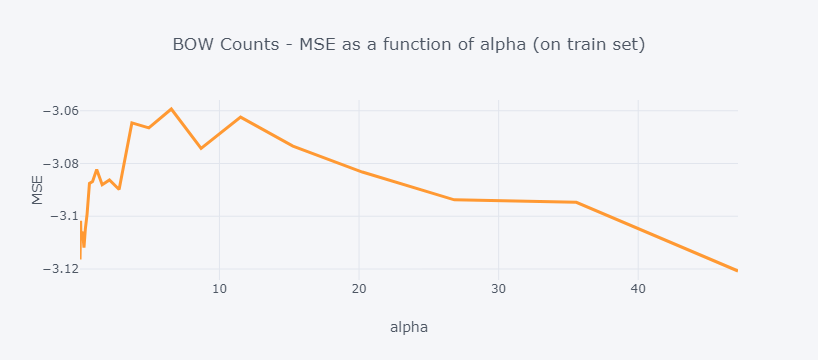

In [55]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [56]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

6.551285568595509 3.05934479659521


#### Optimal Model : training the model with the best alpha, on the train set:

In [57]:
#
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=6.551285568595509)

In [58]:
test_data['ridge2_predicted_points'] = model.predict(clean_bow_counts_test)

In [59]:
ridge2_stats = calc_prediction_quality(test_data, 'ridge2_predicted_points','points')
ridge2_stats

MSE    2.917024
MAE    1.349477
R2     0.693478
dtype: float64

In [60]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats, ridge2_stats], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats', 'ridge2_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.516897,2.524463,-0.000038
baseline_2,9.020636,2.449213,0.052110
baseline_3,8.526019,2.367821,0.104084
ridge_stats,2.890164,1.344363,0.696301
ridge2_stats,2.917024,1.349477,0.693478


#### Are there outliars in the encoded features ?

country           AxesSubplot(0.125,0.657941;0.227941x0.222059)
province       AxesSubplot(0.398529,0.657941;0.227941x0.222059)
region_1       AxesSubplot(0.672059,0.657941;0.227941x0.222059)
region_2          AxesSubplot(0.125,0.391471;0.227941x0.222059)
taster_name    AxesSubplot(0.398529,0.391471;0.227941x0.222059)
variety        AxesSubplot(0.672059,0.391471;0.227941x0.222059)
winery               AxesSubplot(0.125,0.125;0.227941x0.222059)
price             AxesSubplot(0.398529,0.125;0.227941x0.222059)
points            AxesSubplot(0.672059,0.125;0.227941x0.222059)
dtype: object

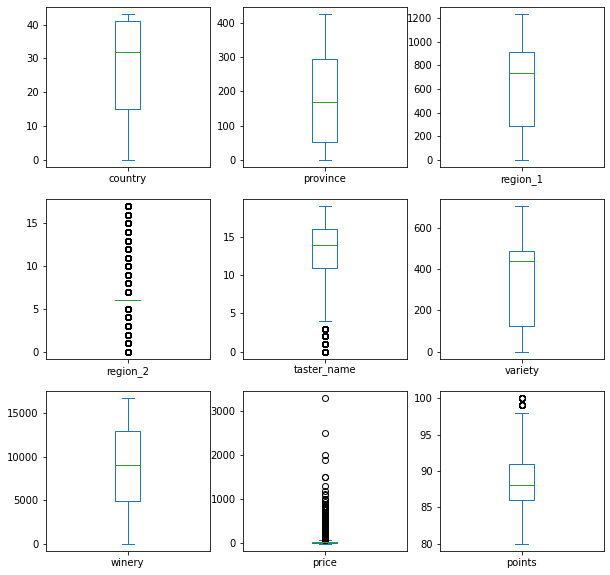

In [61]:
train_encoded_features.plot(kind='box', subplots=True, figsize=(10,10), layout=(3,3))

import numpy as np
from scipy import stats
train_encoded_features[(np.abs(stats.zscore(train_encoded_features)) < 3).all(axis=1)]


In [62]:
#removing the 'price' feature as it's showing a lot of outliars:
encoded_features2 = wine_reviews[categorical_features].apply(lambda col: le.fit_transform(col.fillna('NA')))
encoded_features2['points'] = wine_reviews.points
encoded_features2.head()

,country,province,region_1,region_2,taster_name,variety,winery,points
0,22,332,424,6,9,691,11608,87
1,32,108,738,6,16,451,12956,87
2,41,269,1218,17,15,437,13018,87
3,41,218,549,6,0,480,14390,87
4,41,269,1218,17,15,441,14621,87


In [63]:
encoded_features2.shape

(119988, 8)

In [64]:
# cols = ['taster_name'] # one or more

# Q1 = encoded_features2[cols].quantile(0.25)
# Q3 = encoded_features2[cols].quantile(0.75)
# IQR = Q3 - Q1

# encoded_features2 = encoded_features2[~((encoded_features2[cols] < (Q1 - 1.5 * IQR)) |(encoded_features2[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
# encoded_features2.shape

In [65]:
# encoded_features2.plot(kind='box', subplots=True, figsize=(10,10), layout=(3,3))

In [66]:
len(wine_reviews)

119988

In [67]:
train_encoded_features2 = encoded_features2[encoded_features2.index.isin(train_data.index)]
test_encoded_features2 = encoded_features2[encoded_features2.index.isin(test_data.index)]
assert(len(train_encoded_features2) + len(test_encoded_features2) == len(wine_reviews))

In [68]:
train_features_spares_matrix2 = coo_matrix(train_encoded_features2)
train_united_features2 = hstack((clean_bow_counts_train ,train_features_spares_matrix2))

In [69]:
%%capture
search_grid = np.logspace(-2, 4, num=50, endpoint=True, base=10.0)
MSE_by_alpha = []
for alpha in search_grid:
    model = Ridge(alpha=alpha)
    avg_score = cross_val_score(model, train_united_features2, y = train_data.points, cv = 10, scoring = 'neg_mean_squared_error').mean()
    MSE_by_alpha.append((alpha,avg_score))

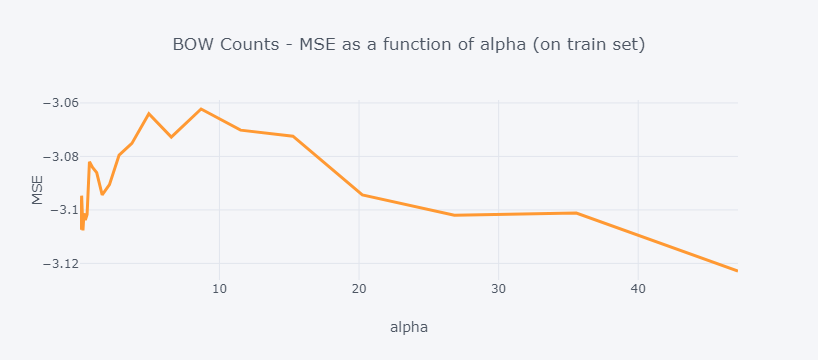

In [70]:
cv_results = pd.DataFrame(MSE_by_alpha, columns = ['alpha', 'MSE'])
cv_results.query('alpha < 50').set_index('alpha').MSE.iplot(title = 'BOW Counts - MSE as a function of alpha (on train set)', xTitle = 'alpha', yTitle = 'MSE', width = 3, hline=(0,0))

In [71]:
opt_alpha, max_MSE = cv_results.loc[cv_results.MSE.idxmax()]
print(opt_alpha, -max_MSE)

8.68511373751352 3.062273596885497


In [72]:
model = Ridge(alpha=opt_alpha)
model.fit(clean_bow_counts_train, train_data.points)

Ridge(alpha=8.68511373751352)

In [73]:
test_data['ridge3_predicted_points'] = model.predict(clean_bow_counts_test)

In [74]:
ridge3_stats = calc_prediction_quality(test_data, 'ridge3_predicted_points','points')
ridge3_stats

MSE    2.903470
MAE    1.346867
R2     0.694903
dtype: float64

In [132]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats, ridge2_stats, ridge3_stats], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats', 'ridge2_stats', 'ridge3_stats'])
all_compared

,MSE,MAE,R2
baseline_1,9.516897,2.524463,-0.000038
baseline_2,9.020636,2.449213,0.052110
baseline_3,8.526019,2.367821,0.104084
ridge_stats,2.890164,1.344363,0.696301
ridge2_stats,2.917024,1.349477,0.693478
ridge3_stats,2.903470,1.346867,0.694903


Removing the "price" feature improves the performance, but strangely it remains worse than the model that used the description only (BOW)

### 16.05.22 19h45 N-hot encoding

<div class="alert alert-block alert-warning">
<b>TBD</b>
</div>

In [133]:
#### Bag of words (One-hot-encoding) for Train

## Deep Learning approaches

### Fully connected network on the text only

1. Refaire le code
2. definir le voc vocab size
3. def la taille de la sequence (60) sequence length
4. text vectorization layer
5. std function, pas besoin de changer
6. train le reseau de neurones
7. play with nb of neurons, nb of dropouts
8. instead of averaging, do concatenation. Search in google sthg like "reshape"
9. comparison with Baselines, Trees, Classic NLP...



#### Tokenization

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

What is a good size for the vocabulary? 

In [27]:
wine_reviews.description.apply(lambda x: len(x.split(' '))).quantile([0.95, 0.99])

0.95    60.0
0.99    72.0
Name: description, dtype: float64

In [28]:
vocab_size = 32000
sequence_length = 60

# Use the text vectorization layer to normalize, split, and map strings to integers. Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    #standardize=lambda text: tf.strings.lower(text), # You can use your own normalization function here
    standardize='lower_and_strip_punctuation', # Or you can use a pre-made normalization function
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

In [29]:
vectorize_layer.adapt(train_data['description'])

In [30]:
sample_description = train_data['description'].sample().iloc[0]
print(sample_description)
vectorize_layer(sample_description)

Proof again from Pierre Luneau that Muscadet can age. This wine, 11 years old, still tastes fresh. The only concession to age is the loss of the high green primary fruits, but the flavors have then rounded out, still creamy, still full of vivacious acidity, but now with almonds, some toast and ripeness.


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([ 4741,  1753,    22,  5361, 19256,    19,  3456,   348,   129,
           7,     9,  1780,    86,   470,   119,   193,    39,     3,
         386, 16124,    13,   129,     8,     3,  9811,     5,     3,
         284,    77,  1120,    47,    23,     3,    10,   273,   341,
         265,    89,   119,   125,   119,    69,     5,  2070,    20,
          23,    44,     6,  1287,    76,   126,     2,   432,     0,
           0,     0,     0,     0,     0,     0], dtype=int64)>

In [31]:
for token in vectorize_layer(sample_description).numpy()[:20]:
    print(f"{token} ---> ",vectorize_layer.get_vocabulary()[token])

4741 --->  proof
1753 --->  again
22 --->  from
5361 --->  pierre
19256 --->  luneau
19 --->  that
3456 --->  muscadet
348 --->  can
129 --->  age
7 --->  this
9 --->  wine
1780 --->  11
86 --->  years
470 --->  old
119 --->  still
193 --->  tastes
39 --->  fresh
3 --->  the
386 --->  only
16124 --->  concession


# description only

#### Modeling

In [33]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 hidden_layer (Dense)        (None, 164)               2788      
                                                                 
 dropout (Dropout)           (None, 164)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 1

In [56]:
tf.keras.utils.plot_model(model, show_dtype=False, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [36]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['mean_squared_error','mean_absolute_error'])

In [37]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 7s 9ms/step - loss: 21.8946 - mean_squared_error: 1356.3291 - mean_absolute_error: 21.8946 - val_loss: 2.4569 - val_mean_squared_error: 9.0714 - val_mean_absolute_error: 2.4569
Epoch 2/20
750/750 [==============================] - 6s 8ms/step - loss: 3.4219 - mean_squared_error: 18.4191 - mean_absolute_error: 3.4219 - val_loss: 1.7015 - val_mean_squared_error: 4.6028 - val_mean_absolute_error: 1.7015
Epoch 3/20
750/750 [==============================] - 6s 8ms/step - loss: 3.1726 - mean_squared_error: 15.8810 - mean_absolute_error: 3.1726 - val_loss: 1.5130 - val_mean_squared_error: 3.6474 - val_mean_absolute_error: 1.5130
Epoch 4/20
750/750 [==============================] - 6s 8ms/step - loss: 3.1063 - mean_squared_error: 15.1913 - mean_absolute_error: 3.1063 - val_loss: 1.4970 - val_mean_squared_error: 3.6175 - val_mean_absolute_error: 1.4970
Epoch 5/20
750/750 [==============================] - 7s 9ms/step - loss: 3.0814 - mean_

### Simple NN Prediction & Evaluation

In [38]:
test_data['dnn_prediction'] = model.predict(test_data[text_col])

750/750 [==============================] - 1s 1ms/step


In [39]:
dnn_stats = calc_prediction_quality(test_data, 'dnn_prediction', target_col)
dnn_stats

MSE    3.012944
MAE    1.365752
R2     0.686983
dtype: float64

In [41]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats, ridge2_stats,ridge3_stats,dnn_stats], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats', 'ridge2_stats','ridge3_stats', 'dnn_prediction'])
all_compared

NameError: name 'ridge_stats' is not defined

### Descriptions words concatinated

In [40]:
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras import Sequential

In [41]:
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Reshape((embedding_dim * sequence_length, ), name='concat_words'),
    Dense(164, activation='tanh', name='hidden_layer'),
    Dropout(0.7),
    Dense(1, name = 'output_layer')
])

In [42]:
model.compile(
    optimizer=tf.optimizers.Adam(), loss='mean_absolute_error', metrics=['mean_squared_error','mean_absolute_error'])

In [68]:
tf.keras.utils.plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [44]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=128,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
750/750 [==============================] - 8s 9ms/step - loss: 24.7436 - mean_squared_error: 1141.3456 - mean_absolute_error: 24.7436 - val_loss: 2.6636 - val_mean_squared_error: 10.9388 - val_mean_absolute_error: 2.6636
Epoch 2/20
750/750 [==============================] - 7s 9ms/step - loss: 8.7119 - mean_squared_error: 118.9455 - mean_absolute_error: 8.7119 - val_loss: 2.6650 - val_mean_squared_error: 10.9575 - val_mean_absolute_error: 2.6650
Epoch 3/20
750/750 [==============================] - 7s 9ms/step - loss: 8.6580 - mean_squared_error: 117.7718 - mean_absolute_error: 8.6580 - val_loss: 2.6449 - val_mean_squared_error: 10.7387 - val_mean_absolute_error: 2.6449
Epoch 4/20
750/750 [==============================] - 7s 9ms/step - loss: 8.6558 - mean_squared_error: 117.1136 - mean_absolute_error: 8.6558 - val_loss: 2.7237 - val_mean_squared_error: 11.6958 - val_mean_absolute_error: 2.7237
Epoch 5/20
750/750 [==============================] - 7s 9ms/step - loss: 8.6526 

In [45]:
test_data['dnn2_prediction'] = model.predict(test_data[text_col])

750/750 [==============================] - 1s 1ms/step


In [46]:
dnn2_stats = calc_prediction_quality(test_data, 'dnn2_prediction', target_col)
dnn2_stats

MSE    4.353318
MAE    1.648566
R2     0.547731
dtype: float64

In [155]:
all_compared = pd.DataFrame([b1_stats, b2_stats, b3_stats, ridge_stats, ridge2_stats,ridge3_stats,dnn_stats, dnn2_stats], index=['baseline_1', 'baseline_2','baseline_3', 'ridge_stats', 'ridge2_stats','ridge3_stats', 'dnn_prediction', 'dnn2_prediction'])
all_compared

,MSE,MAE,R2
baseline_1,9.516897,2.524463,-0.000038
baseline_2,9.020636,2.449213,0.052110
baseline_3,8.526019,2.367821,0.104084
ridge_stats,2.890164,1.344363,0.696301
ridge2_stats,2.917024,1.349477,0.693478
ridge3_stats,2.903470,1.346867,0.694903
dnn_prediction,3.095490,1.389972,0.674725
dnn2_prediction,10.508033,2.614314,-0.104186


In [62]:
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,description
0,22,332,424,6,9,691,11608,-1.0,87,16394
1,32,108,738,6,16,451,12956,15.0,87,99986
2,41,269,1218,17,15,437,13018,14.0,87,75451
3,41,218,549,6,0,480,14390,13.0,87,60489
4,41,269,1218,17,15,441,14621,65.0,87,55693


In [63]:
encoded_features.shape

(119988, 10)

In [64]:
encoded_description_column = le.fit_transform(wine_reviews.description)
encoded_features['description'] = encoded_description_column
encoded_features.head()

,country,province,region_1,region_2,taster_name,variety,winery,price,points,description
0,22,332,424,6,9,691,11608,-1.0,87,16394
1,32,108,738,6,16,451,12956,15.0,87,99986
2,41,269,1218,17,15,437,13018,14.0,87,75451
3,41,218,549,6,0,480,14390,13.0,87,60489
4,41,269,1218,17,15,441,14621,65.0,87,55693


In [65]:
column_names = ['country','province','region_1','region_2','taster_name','variety','winery','price','points','description']

train_data = encoded_features.sample(frac=0.8)[column_names]
test_data = encoded_features[~encoded_features.index.isin(train_data.index)][column_names]
assert(len(test_data) + len(train_data) == len(encoded_features))

In [50]:
model = Sequential([
    Dense(5, activation='relu',name = 'layer1',input_dim=9),
    Dense(1, activation='linear',name = 'layer3')
])

model.compile(loss='mean_squared_error',
              optimizer=tf.optimizers.Adam(),
              metrics=['mean_squared_error','mean_absolute_error'])

model.summary()
# model = tf.keras.Sequential([
#     tf.keras.Input(shape=(1,), dtype=tf.string),
#     Dense(164, activation='tanh', name='hidden_layer'),
#     Dropout(0.2),
#     Dense(1, name = 'output_layer')
# ])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 5)                 50        
                                                                 
 layer3 (Dense)              (None, 1)                 6         
                                                                 
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 5)                 50        
                                                                 
 layer3 (Dense)              (None, 1)                 6         
                                                                 
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


In [52]:
# model.compile(
#     optimizer=tf.optimizers.Adam(),
#     loss='mean_absolute_error',
#     metrics=['mean_squared_error','mean_absolute_error'])

In [53]:
%%time

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)
# encoded_features2
    # train_data.drop(cols, axis=1),

cols = ['points']
train_data_without_points = train_data.drop(cols, axis=1)
test_data_without_points = test_data.drop(cols, axis=1)
    
model.fit(
          train_data_without_points.values,
          train_data['points'],
          validation_data=(test_data_without_points, test_data['points']),
          batch_size=128,
          epochs=30,
          verbose=True,
          callbacks=[early_stopping_monitor])
    
# history = model.fit(
#    ,
#     train_data[target_col],
#     epochs=20,
#     batch_size=128,
#     verbose=1,    
#     callbacks=[early_stopping_monitor],
#     validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/30
750/750 [==============================] - 1s 1ms/step - loss: 217359392.0000 - mean_squared_error: 217359392.0000 - mean_absolute_error: 11523.9082 - val_loss: 27103118.0000 - val_mean_squared_error: 27103118.0000 - val_mean_absolute_error: 4567.2451
Epoch 2/30
750/750 [==============================] - 1s 1ms/step - loss: 11062524.0000 - mean_squared_error: 11062524.0000 - mean_absolute_error: 2785.1875 - val_loss: 3728013.2500 - val_mean_squared_error: 3728013.2500 - val_mean_absolute_error: 1666.2394
Epoch 3/30
750/750 [==============================] - 1s 1ms/step - loss: 1931800.8750 - mean_squared_error: 1931800.8750 - mean_absolute_error: 1165.0057 - val_loss: 889941.2500 - val_mean_squared_error: 889941.2500 - val_mean_absolute_error: 797.5916
Epoch 4/30
750/750 [==============================] - 1s 1ms/step - loss: 515961.8125 - mean_squared_error: 515961.8125 - mean_absolute_error: 593.1364 - val_loss: 272489.6562 - val_mean_squared_error: 272489.6562 - val_mean_a

In [145]:
#final project : faire par nous même external embeddings, plus encore une/des autre approche (RNN, LSTM)

# Using external embedding (description feature only)

In [80]:
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras

path_to_glove_file = "D:/Users/1/Desktop/DS-Thechnion/Python_ML-2022/Final project/data/glove.6B.100d.txt"

In [81]:
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [91]:
num_tokens = len(embeddings_index) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # Words not found in embedding index will be all-zeros.
#         # This includes the representation for "padding" and "OOV"
#         embedding_matrix[i] = embedding_vector
#         hits += 1
#     else:
#         misses += 1
# print("Converted %d words (%d misses)" % (hits, misses))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [90]:
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
    name="embedding"
)

In [47]:
# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Users\\1\\Desktop\\DS-Thechnion\\Python_ML-2022\\Final project\\data\\glove.6B.100d.txt'

In [ ]:
embedding_dim=100

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(32, activation='tanh', name='hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

# LSTM

In [66]:
vocab_size = 32000
sequence_length = 60

vectorize_layer2 = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=vocab_size,    
    split='whitespace',
    output_mode='int',
    name = 'Text_processing',
    output_sequence_length=sequence_length)

vectorize_layer2.adapt(train_data['description'])

#### Modeling

In [67]:
from keras.layers import LSTM
embedding_dim=16

model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer2,
    Embedding(vocab_size, embedding_dim , input_length = sequence_length , name="embedding"),
    LSTM(32,activation="tanh",name='lstm_hidden_layer'),
    Dropout(0.2),
    Dense(1, name = 'output_layer')
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_processing (TextVector  (None, 60)               0         
 ization)                                                        
                                                                 
 embedding (Embedding)       (None, 60, 16)            512000    
                                                                 
 lstm_hidden_layer (LSTM)    (None, 32)                6272      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 518,305
Trainable params: 518,305
Non-trainable params: 0
________________________________________________

In [68]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['mean_squared_error','mean_absolute_error'])

In [69]:
%%time
text_col, target_col = 'description', 'points'

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_squared_error',
    min_delta=0,
    patience=2,
    verbose=0,
    restore_best_weights=True
)

history = model.fit(
    train_data[text_col],
    train_data[target_col],
    epochs=20,
    batch_size=32,
    verbose=1,    
    callbacks=[early_stopping_monitor],
    validation_data = (test_data[text_col], test_data[target_col]))

Epoch 1/20
3000/3000 [==============================] - 53s 17ms/step - loss: 34.2222 - mean_squared_error: 1812.0845 - mean_absolute_error: 34.2222 - val_loss: 2.6267 - val_mean_squared_error: 10.5990 - val_mean_absolute_error: 2.6267
Epoch 2/20
3000/3000 [==============================] - 50s 17ms/step - loss: 6.5403 - mean_squared_error: 67.3275 - mean_absolute_error: 6.5403 - val_loss: 2.5752 - val_mean_squared_error: 10.1250 - val_mean_absolute_error: 2.5752
Epoch 3/20
3000/3000 [==============================] - 50s 17ms/step - loss: 6.4523 - mean_squared_error: 65.9730 - mean_absolute_error: 6.4523 - val_loss: 2.5723 - val_mean_squared_error: 10.1023 - val_mean_absolute_error: 2.5723
Epoch 4/20
3000/3000 [==============================] - 50s 17ms/step - loss: 6.4029 - mean_squared_error: 64.6087 - mean_absolute_error: 6.4029 - val_loss: 2.6284 - val_mean_squared_error: 10.6165 - val_mean_absolute_error: 2.6284
Epoch 5/20
3000/3000 [==============================] - 51s 17ms/ste

In [70]:
test_data['dnn3_lstm_prediction'] = model.predict(test_data[text_col])

750/750 [==============================] - 4s 4ms/step


In [71]:
dnn3_lstm_prediction = calc_prediction_quality(test_data, 'dnn3_lstm_prediction', target_col)
dnn3_lstm_prediction

MSE    3.376467
MAE    1.456329
R2     0.643004
dtype: float64